# Plot PPSD on the BP network
2021.05.25 Kurama Okubo

This notebook plot PPSD on the BP network to check the consistency in ambient seismic noise strength.

2022.06.22: update to compare with UW backup data.

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib.patches import Rectangle, Circle, Ellipse
import matplotlib.cm as cm

import seaborn as sns # to plot heatmap
import matplotlib.dates as mdates
import itertools


In [2]:
figdir = "./figure_DataAvailability_BP"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [46]:
datacase = "seisremoveeq"
csv_file = f"./csv_dataavailability_uw/dataavailability_{datacase}_uw_2002-2022.csv"
datatype = csv_file.split('/')[-1][:-4]
df_origin = pd.read_csv(csv_file)

## Merge channels between ..BP* and .40.SP*

As the instruments are replaced during 2011-12, we combine BP* and SP* as single channel 

In [47]:
def get_sta_nochan(x):
    net, sta, loc, chan = x.split(".")
    return "{}.{}-{}".format(net, sta, chan[-1])

df_origin['sta_nochan'] = df_origin['station'].apply(get_sta_nochan)
stations = df_origin['sta_nochan'].unique()

## convert to datetime

In [48]:
def datestr2date(x):
    return pd.to_datetime(x.split('T')[0], format='%Y-%m-%d')
    
df_origin['plotdate'] = df_origin['date'].apply(datestr2date)

## Plot heatmap

sns.heatmap is a categorical plot, so we cannot use DatetimeLocater. So we first prepare the plotting dateframe with uniform time vector, then prepare xticks and xticklabels independently.

work flow:
1. Initialize dataframe with uniform time vector
2. prepare dataframe for update. Update if seisdata is available using updatekey
3. plot using sns.heatmap. As it is categorical, prepare xticks for yearly locator.

In [49]:
# make uniform time vector
starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

download_timeunit = 86400
st_center = (download_timeunit/86400)/2 # mid time of the day
date_range_st = starttime + datetime.timedelta(days=st_center) # day
datefreq = '1D'
uniformdates = pd.date_range(start=date_range_st, end=endtime, freq=datefreq)
uniform_tvec = uniformdates.date
uniform_tvec

array([datetime.date(2002, 1, 1), datetime.date(2002, 1, 2),
       datetime.date(2002, 1, 3), ..., datetime.date(2022, 5, 29),
       datetime.date(2022, 5, 30), datetime.date(2022, 5, 31)],
      dtype=object)

In [50]:
# make new dataframe with uniform tvec; set np.nan if no data is available at that date
stationdate = list(itertools.product(stations, uniform_tvec))
# data_init = [["{}__{}".format(stationdate[i][0], stationdate[i][1]), stationdate[i][0], stationdate[i][1], np.NaN, np.NaN] for i in range(len(stationdate))]
data_init = [["{}__{}".format(stationdate[i][0], stationdate[i][1]), stationdate[i][0], stationdate[i][1], 0.0, 0.0] for i in range(len(stationdate))]

In [51]:
# initialize dataframe
df_dataavail_all = pd.DataFrame(data_init,
                                 columns=['updatekey', 'sta_nochan', 'plotdate_uni', 'data_fraction', 'removal_fraction'])
df_dataavail_all['plotdate_uni'] = pd.to_datetime(df_dataavail_all['plotdate_uni'])
df_dataavail_all.set_index('updatekey', inplace=True)

In [52]:
# prepare dataframe for update df
df_temp = df_origin.filter(items=['sta_nochan', 'plotdate', 'data_fraction', 'removal_fraction'])
df_temp.rename(columns = {'plotdate': 'plotdate_uni'}, inplace = True)
df_temp['updatekey'] = df_temp['sta_nochan'].astype(str) + '__' + df_temp['plotdate_uni'].astype(str)
df_temp.set_index('updatekey',inplace=True)

In [53]:
# Manipulate duplication due to instrumental replacement from ..BP* to .40.SP* 
df_temp[df_temp.index.duplicated(keep=False)].head()

,sta_nochan,plotdate_uni,data_fraction,removal_fraction
updatekey,,,,
BP.EADB-1__2011-07-20,BP.EADB-1,2011-07-20,0.962494,0.037500
BP.EADB-2__2011-07-20,BP.EADB-2,2011-07-20,0.929164,0.070833
BP.EADB-3__2011-07-20,BP.EADB-3,2011-07-20,0.952771,0.047223
BP.EADB-1__2011-07-20,BP.EADB-1,2011-07-20,0.997222,0.002778
BP.EADB-2__2011-07-20,BP.EADB-2,2011-07-20,0.997222,0.002778


In [54]:
# Since all overlapped data has a fraction of 1.0, remove one of the rows
df_temp = df_temp.reset_index().drop_duplicates(subset='updatekey').set_index('updatekey')

In [55]:
# update dictionary
df_dataavail_all.update(df_temp)
df_dataavail_all.to_csv('test.csv')

In [56]:
df_plt = df_dataavail_all.pivot(index='sta_nochan', columns='plotdate_uni', values='data_fraction')
df_plt

plotdate_uni,2002-01-01,2002-01-02,2002-01-03,2002-01-04,2002-01-05,2002-01-06,2002-01-07,2002-01-08,2002-01-09,2002-01-10,...,2022-05-22,2022-05-23,2022-05-24,2022-05-25,2022-05-26,2022-05-27,2022-05-28,2022-05-29,2022-05-30,2022-05-31
sta_nochan,,,,,,,,,,,,,,,,,,,,,
BP.CCRB-1,0.712226,0.868749,0.692331,0.693554,0.677024,0.690726,0.691566,0.834930,0.720818,0.795048,...,0.967122,0.995139,0.996528,0.989583,0.924997,0.993056,0.974305,0.986804,0.996528,0.997900
BP.CCRB-2,0.807991,0.868749,0.835041,0.611987,0.815515,0.860144,0.780380,0.749796,0.841427,0.840671,...,0.971362,0.996528,0.996528,0.997916,0.938884,0.995139,0.972221,0.988194,0.996528,0.996524
BP.CCRB-3,0.816030,0.868749,0.799802,0.832970,0.812727,0.839302,0.791705,0.584377,0.732955,0.810123,...,0.971642,0.995139,0.991667,0.984722,0.959718,0.982637,0.977083,0.991666,0.996528,0.993050
BP.EADB-1,0.947914,0.961109,0.979164,0.939580,0.950690,0.962496,0.982638,0.974998,0.969443,0.954161,...,0.995139,1.000000,1.000000,1.000000,0.940968,0.995832,0.962499,1.000000,1.000000,1.000000
BP.EADB-2,0.988194,0.995832,0.993749,0.982637,0.984027,0.984720,0.988194,0.974997,0.996528,0.991666,...,0.996528,1.000000,0.996528,1.000000,0.963192,0.987499,0.959027,0.993056,0.994444,0.996526
BP.EADB-3,0.911802,0.935414,0.904856,0.933332,0.918747,0.874997,0.906942,0.904855,0.918744,0.930550,...,0.981943,0.986804,0.990972,0.978470,0.963192,0.934719,0.922912,0.947913,1.000000,0.990972
BP.FROB-1,0.938885,0.929163,0.940275,0.899997,0.911798,0.939583,0.949997,0.972220,0.967358,0.682933,...,0.891659,0.914577,0.924999,0.954166,0.908322,0.924993,0.842354,0.788185,0.817353,0.740269
BP.FROB-2,0.762496,0.781942,0.736105,0.872885,0.831246,0.931927,0.791624,0.923606,0.929845,0.653224,...,0.912494,0.896521,0.925692,0.936108,0.811798,0.829857,0.839576,0.820132,0.830550,0.835409
BP.FROB-3,1.000000,0.979164,1.000000,0.994444,0.993054,0.990972,0.993055,0.993056,1.000000,0.681143,...,0.895133,0.914577,0.925000,0.954859,0.872909,0.856938,0.773604,0.752074,0.710405,0.649985


In [57]:
# manipulate xtick label to plot yearly label
xticks_all = [i + 0.5 for i in range(0, len(df_plt.columns))]
xticks = []
xlabels = []
for i, x in enumerate(df_plt.columns):
    if (x.month == 1) and (x.day == 1):
        xticks.append(xticks_all[i])
        xlabels.append("{}".format(x.year))

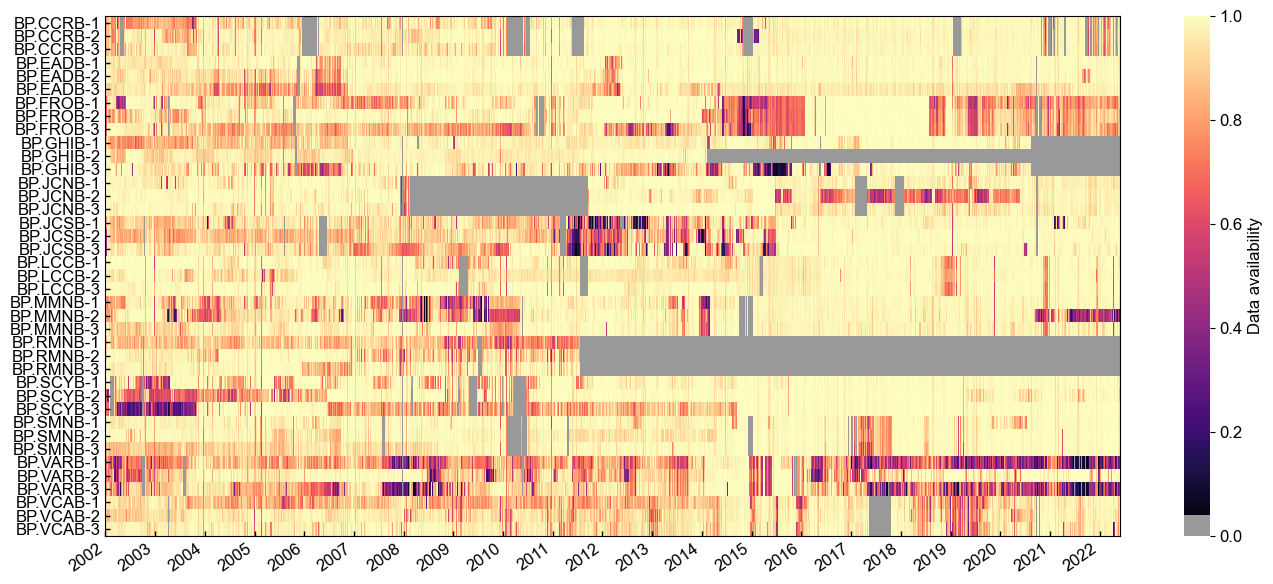

In [58]:
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

cmap1 = sns.color_palette("magma", as_cmap=True)
# manipulate colorpallet so than 0 is white
cmap1._lut[0:10] = np.array([ 0.6, 0.6,  0.6,  1.0])

# plot heatmap
sns.heatmap(df_plt, linewidth = 0, edgecolor="black", cmap=cmap1, ax=ax, vmin = 0.0, vmax=1.0,
            yticklabels=1, cbar_kws={"orientation": "vertical", "label":"Data availability"})


# decorate figure
ax.set_xticks(xticks)
ax.set_xticklabels(labels=xlabels, rotation=35, ha='right')
ax.tick_params(direction="in", width=1.0)
ax.set_xlabel(None)
ax.set_ylabel(None)
# show box outline
for _, spine in ax.spines.items():
    spine.set_visible(True)
    
plt.tight_layout()

plt.savefig(figdir+"/DataAvailability_{}.png".format(datacase), format="png", dpi=150)


In [59]:
stalist = np.unique([x.split('-')[0].split('.')[-1] for x in stations])
print(stalist)
len(stalist)

['CCRB' 'EADB' 'FROB' 'GHIB' 'JCNB' 'JCSB' 'LCCB' 'MMNB' 'RMNB' 'SCYB'
 'SMNB' 'VARB' 'VCAB']


13

## Compare the data fraction between tacc and uw

In [17]:
csv_file_uw = "./csv_dataavailability_uw/dataavailability_rawseismicdata_uw_2002-2022.csv"
csv_file_tacc = "./csv_dataavailability_tacc/dataavailability_rawseismicdata_tacc.csv"

df_origin_uw = pd.read_csv(csv_file_uw)
df_origin_tacc = pd.read_csv(csv_file_tacc)

In [18]:
df_origin_uw['plotdate'] = df_origin_uw['date'].apply(datestr2date)
df_origin_tacc['plotdate'] = df_origin_tacc['date'].apply(datestr2date)

In [19]:
df_origin_tacc

,station,date,data_fraction,removal_fraction,plotdate
0,BP.CCRB..BP1,2002-01-01T11:59:59.5,0.997987,0.0,2002-01-01
1,BP.CCRB..BP1,2002-01-02T11:59:59.5,0.999405,0.0,2002-01-02
2,BP.CCRB..BP1,2002-01-03T11:59:59.5,0.997642,0.0,2002-01-03
3,BP.CCRB..BP1,2002-01-04T11:59:59.5,0.998904,0.0,2002-01-04
4,BP.CCRB..BP1,2002-01-05T11:59:59.5,0.999940,0.0,2002-01-05
...,...,...,...,...,...
243634,BP.VCAB.40.SP3,2020-08-27T12:00:00,1.000000,0.0,2020-08-27
243635,BP.VCAB.40.SP3,2020-08-28T12:00:00,1.000000,0.0,2020-08-28
243636,BP.VCAB.40.SP3,2020-08-29T12:00:00,1.000000,0.0,2020-08-29
243637,BP.VCAB.40.SP3,2020-08-30T12:00:00,1.000000,0.0,2020-08-30


In [20]:
# number of data
df_origin_tacc_eq = df_origin_tacc[["station", "plotdate"]]
df_origin_uw_eq = df_origin_uw[["station", "plotdate"]]

In [21]:
# number of data
et_tacc = datetime.datetime(2020, 9, 1)
df_origin_tacc_eq = df_origin_tacc[["station", "plotdate"]].reset_index(drop=True)
df_origin_uw_eq = df_origin_uw[["station", "plotdate"]]
df_origin_uw_eq = df_origin_uw_eq[df_origin_uw_eq["plotdate"] < et_tacc].reset_index(drop=True)

df_origin_uw_trim = df_origin_uw[df_origin_uw["plotdate"] < et_tacc].reset_index(drop=True)


print(f"comparison of data dates: {df_origin_uw_eq.equals(df_origin_tacc_eq)}")

comparison of data dates: True


In [22]:
df_origin_uw_trim

,station,date,data_fraction,removal_fraction,plotdate
0,BP.CCRB..BP1,2002-01-01T11:59:59.500,0.997892,0.0,2002-01-01
1,BP.CCRB..BP1,2002-01-02T11:59:59.500,0.999531,0.0,2002-01-02
2,BP.CCRB..BP1,2002-01-03T11:59:59.500,0.997142,0.0,2002-01-03
3,BP.CCRB..BP1,2002-01-04T11:59:59.500,0.998904,0.0,2002-01-04
4,BP.CCRB..BP1,2002-01-05T11:59:59.500,0.999940,0.0,2002-01-05
...,...,...,...,...,...
243634,BP.VCAB.40.SP3,2020-08-27T12:00:00,1.000000,0.0,2020-08-27
243635,BP.VCAB.40.SP3,2020-08-28T12:00:00,1.000000,0.0,2020-08-28
243636,BP.VCAB.40.SP3,2020-08-29T12:00:00,1.000000,0.0,2020-08-29
243637,BP.VCAB.40.SP3,2020-08-30T12:00:00,1.000000,0.0,2020-08-30


In [23]:
df_origin_tacc

,station,date,data_fraction,removal_fraction,plotdate
0,BP.CCRB..BP1,2002-01-01T11:59:59.5,0.997987,0.0,2002-01-01
1,BP.CCRB..BP1,2002-01-02T11:59:59.5,0.999405,0.0,2002-01-02
2,BP.CCRB..BP1,2002-01-03T11:59:59.5,0.997642,0.0,2002-01-03
3,BP.CCRB..BP1,2002-01-04T11:59:59.5,0.998904,0.0,2002-01-04
4,BP.CCRB..BP1,2002-01-05T11:59:59.5,0.999940,0.0,2002-01-05
...,...,...,...,...,...
243634,BP.VCAB.40.SP3,2020-08-27T12:00:00,1.000000,0.0,2020-08-27
243635,BP.VCAB.40.SP3,2020-08-28T12:00:00,1.000000,0.0,2020-08-28
243636,BP.VCAB.40.SP3,2020-08-29T12:00:00,1.000000,0.0,2020-08-29
243637,BP.VCAB.40.SP3,2020-08-30T12:00:00,1.000000,0.0,2020-08-30


In [24]:
diff_datafrac = df_origin_tacc["data_fraction"] - df_origin_uw_trim["data_fraction"]

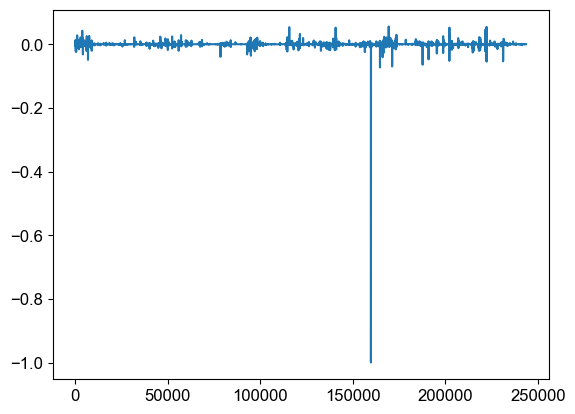

In [25]:
plt.plot(diff_datafrac)
# plt.ylim([-0.1,0.1])
# plt.xlim([0,10000])

In [26]:
np.where(np.abs(diff_datafrac) > 0.5)

(array([159817]),)

Only one date containing more data, while the others contains similar amount of data

In [27]:
npts = int(1728000)
Nnullsignal = 10

1 - (float(Nnullsignal)/float(npts))

0.999994212962963

In [28]:
float(npts-Nnullsignal)

1727990.0

In [29]:
np.where(diff_datafrac > 0.02)

(array([  1091,   2950,   3843,   6251,   6291,   7599,  31961,  46019,
         52402,  57230,  94724,  98402, 114639, 115700, 115701, 121449,
        140741, 167028, 168353, 169419, 170313, 173600, 198851, 202206,
        202231, 202241, 218244, 218373, 218869, 221675, 222275, 222287,
        222312]),)

In [30]:
df_origin_tacc.iloc[97028]

station                      BP.JCSB..BP2
date                2002-12-27T11:59:59.5
data_fraction                    0.745072
removal_fraction                        0
plotdate              2002-12-27 00:00:00
Name: 97028, dtype: object

In [31]:
df_origin_uw.iloc[97028]

station                  BP.JCNB.40.SP3
date                2012-04-04T12:00:00
data_fraction                         1
removal_fraction                      0
plotdate            2012-04-04 00:00:00
Name: 97028, dtype: object